In [1]:
import numpy as np 

## to specify the dataset

In [2]:
Y_0 = np.load('dataset_2/y_T0.npy')
Y_1 = np.load('dataset_2/y_T1.npy')
Y_2 = np.load('dataset_2/y_T2.npy')
Y = np.concatenate((Y_0, Y_1, Y_2))

In [3]:
X_0 = np.load('dataset_2/X_T0.npy')
X_1 = np.load('dataset_2/X_T1.npy')
X_2 = np.load('dataset_2/X_T2.npy')

X = np.concatenate((X_0, X_1, X_2))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

In [5]:
# 打印训练集和测试集的0,1占比
print("训练集中 0 的占比：", np.mean(Y_train == 0))
print("训练集中 1 的占比：", np.mean(Y_train == 1))
print("训练集中 2 的占比：", np.mean(Y_train == 2))

print("测试集中 0 的占比：", np.mean(Y_test == 0))
print("测试集中 1 的占比：", np.mean(Y_test == 1))
print("训练集中 2 的占比：", np.mean(Y_test == 2))


训练集中 0 的占比： 0.30434782608695654
训练集中 1 的占比： 0.43478260869565216
训练集中 2 的占比： 0.2608695652173913
测试集中 0 的占比： 0.3333333333333333
测试集中 1 的占比： 0.4166666666666667
训练集中 2 的占比： 0.25


In [6]:
# normalization
def normalize(X, vec_min=None, vec_max=None):
    # with maxmin normalization
    if not vec_min:
        vec_min = np.expand_dims(np.min(X, axis=1), axis=-1)
    if not vec_max:
        vec_max = np.expand_dims(np.max(X, axis=1), axis=-1)
    normalized_data = (X - vec_min) / (vec_max - vec_min)
    return normalized_data, vec_min, vec_max

In [7]:
# standardization
def standardize(X, vec_mean=None, vec_std=None):
    if vec_mean is None:
        vec_mean = np.mean(X, axis=0)
    if vec_std is None:
        vec_std = np.std(X, axis=0)
    standardized_data = (X - vec_mean) / (vec_std)
    return standardized_data, vec_mean, vec_std

In [8]:
from scipy.signal import savgol_filter
def denoise(row, window_size=31, poly_order=4):
    return savgol_filter(row, window_size, poly_order)

In [9]:
X_denoised = np.apply_along_axis(denoise, axis=3, arr=X)
X_train_denoised = np.apply_along_axis(denoise, axis=3, arr=X_train)
X_test_denoised = np.apply_along_axis(denoise, axis=3, arr=X_test)

In [10]:
# with maxmin normalization
# normed_X_train, vec_min, vec_max = normalize(X_train_denoised.reshape(-1, 1701))
# normed_X_test, _, _ = normalize(X_test_denoised.reshape(-1, 1701))

normed_X_train, vec_mean, vec_std = standardize(X_train_denoised.reshape(-1, 1701))
normed_X_test, _, _ = standardize(X_test_denoised.reshape(-1, 1701), vec_mean, vec_std)

normed_X_train = normed_X_train.reshape((-1, 3, 300, 1701))
normed_X_test = normed_X_test.reshape((-1, 3, 300, 1701))

In [11]:
normed_X_test.shape

(12, 3, 300, 1701)

## data augmentation

In [12]:
def swap_noise(x, i, j):
    _, num_wave, num_spectrum, num_feature = x.shape
    res = np.zeros((num_wave, num_spectrum, num_feature))
    for cur in range(num_wave):
        base_mean = np.mean(x[i, cur, :, :], axis=0)
        target_mean = np.mean(x[j, cur, :, :], axis=0)
        res[cur,:,:] = target_mean + ( x[i, cur, :, :] - base_mean)
    return res

In [13]:
from collections import defaultdict
import random
def aug_dataset(x, y, repeat):
    num_sample, num_wave, num_spectrum, num_feature = x.shape
    res_x = x
    res_y = y

    has_used = defaultdict(set)
    for i in range(repeat - 1):
        cur_x = np.zeros((num_sample, num_wave, num_spectrum, num_feature))
        cur_y = y

        for j in range(num_sample):
            has_used[j].add(j)

            random_num = random.randint(0, num_sample - 1)
            while random_num in has_used[j]:
                random_num = random.randint(0, num_sample - 1)
            
            cur_x[j, :, :, :] = swap_noise(x, j, random_num)
        
        res_x = np.concatenate((res_x, cur_x), axis=0)
        res_y = np.concatenate((res_y, cur_y), axis=0)
    
    return res_x, res_y

In [14]:
from collections import defaultdict
import random
def shift_and_add_noise(arr, max_shift=5, noise_std=0.01):
    """
    对输入的 [300, 1701] 数组的每一行进行左右 0~5 的随机位移，并叠加高斯白噪声。
    
    参数:
    - arr: 输入的 [300, 1701] 数组
    - max_shift: 最大位移量，默认为 5
    - noise_std: 高斯白噪声的标准差，默认为 0.01
    
    返回:
    - 处理后的数组
    """
        
    # 初始化结果数组
    result = np.zeros_like(arr)
    
    for i in range(arr.shape[0]):
        shift = np.random.randint(-max_shift, max_shift + 1)
        
        if shift > 0:
            shifted_row = np.pad(arr[i, :-shift], (shift, 0), 'constant')
        elif shift < 0:
            shifted_row = np.pad(arr[i, -shift:], (0, -shift), 'constant')
        else:
            shifted_row = arr[i]
        
        # 叠加高斯白噪声
        noise = np.random.normal(0, noise_std, arr.shape[1])
        result[i] = shifted_row + noise
    
    return result

def aug_dataset_add_noise(x, y, repeat):
    num_sample, num_wave, num_spectrum, num_feature = x.shape
    res_x = x
    res_y = y

    for i in range(repeat - 1):
        cur_x = np.zeros((num_sample, num_wave, num_spectrum, num_feature))
        cur_y = y

        for j in range(num_sample):
            for k in range(num_wave):
                cur_x[j, k, :, :] = shift_and_add_noise(x[j, k, :, :])
        
        res_x = np.concatenate((res_x, cur_x), axis=0)
        res_y = np.concatenate((res_y, cur_y), axis=0)

    return res_x, res_y

In [15]:
aug_X_train, aug_Y_train = aug_dataset_add_noise(X_train, Y_train, 2)
# aug_X_test, aug_Y_test = aug_dataset(X_test, Y_test, 10)

## Phase1 average

In [16]:
def average_multi_spectra(X, Y, num_mean):
    num_sample, num_wave, num_spectrum, num_feature = X.shape 
    tmp = X.reshape(num_sample, num_wave, -1, num_mean, num_feature)
    X_shaped = np.mean(tmp, axis=3).reshape(num_sample, num_wave, int(num_spectrum / num_mean), num_feature)
    Y_shaped = np.repeat(Y, num_spectrum / num_mean)
    return X_shaped, Y_shaped

In [17]:
def shuffle_n_spectra(data, n):
    """
    Shuffles every 'n' spectra for a specific sample and wave in a 4D numpy array.
    
    Parameters:
        data (numpy.ndarray): The 4D array with shape (num_sample, num_wave, num_spectrum, num_feature).
        sample_index (int): The index of the sample to modify.
        wave_index (int): The index of the wave to modify.
        n (int): Number of consecutive spectra to shuffle together.
    """    
    # Calculate the number of complete blocks of 'n' spectra
    target_data = np.copy(data)
    num_blocks = target_data.shape[0] // n
    
    # Shuffle each block of 'n' spectra
    for i in range(num_blocks):
        # Shuffle the spectra in place
        np.random.shuffle(target_data[i*n : (i+1)*n])
        
    # If there are leftover spectra not making up a full block of 'n', optionally shuffle them too
    if target_data.shape[0] % n != 0:
        np.random.shuffle(target_data[num_blocks*n:])
    return target_data




def shuffle_spectra(X, n):
    num_sample, num_wave, num_spectrum, num_feature = X.shape
    result =  np.zeros(X.shape)

    for i in range(num_sample):
        for j in range(num_wave):
            result[i, j, :, :] = shuffle_n_spectra(X[i, j, :, :], n)

    return result

In [18]:
def moving_average_multi_spectra(X, Y, num_mean):
    num_sample, num_wave, num_spectrum, num_feature = X.shape 
    num_spectrum_mean = num_spectrum - num_mean + 1
    result = np.zeros((num_sample, num_wave, num_spectrum_mean, num_feature))
    
    for i in range(num_spectrum_mean):
        result[:, :, i, :] = np.mean(X[:, :, i : i + num_mean, :], axis=2)
    
    return result, np.repeat(Y, num_spectrum_mean)

In [19]:
def combine_waves(X, indices=None):
    _, num_wave, _, num_feature = X.shape
    x = None
    
    if indices is None:
        indices = range(num_wave)
    
    for i in indices:
        if x is None:
            x = X[:, i, :, :].reshape(-1, num_feature)
        else:
            x = np.concatenate((x, X[:, i, :, :].reshape(-1, num_feature)), axis = 1)
    return x

## data smoothing

In [48]:
moved_normed_X_train_T1, Y_train_T1 = moving_average_multi_spectra(normed_X_train[Y_train == 0], Y_train[Y_train == 0], 20)
moved_normed_X_train_T2, Y_train_T2 = moving_average_multi_spectra(normed_X_train[Y_train == 1], Y_train[Y_train == 1], 20)
moved_normed_X_train_T3, Y_train_T3 = moving_average_multi_spectra(normed_X_train[Y_train == 2], Y_train[Y_train == 2], 20)

In [49]:
moved_normed_X_test_T1, Y_test_T1 = moving_average_multi_spectra(normed_X_test[Y_test == 0], Y_test[Y_test == 0], 20)
moved_normed_X_test_T2, Y_test_T2 = moving_average_multi_spectra(normed_X_test[Y_test == 1], Y_test[Y_test == 1], 20)
moved_normed_X_test_T3, Y_test_T3 = moving_average_multi_spectra(normed_X_test[Y_test == 2], Y_test[Y_test == 2], 20)

In [50]:
Y_train_shaped = np.concatenate((Y_train_T1, Y_train_T2, Y_train_T3), axis=0)
Y_test_shaped = np.concatenate((Y_test_T1, Y_test_T2, Y_test_T3), axis = 0)

In [51]:
moved_normed_X_train = np.concatenate((moved_normed_X_train_T1, moved_normed_X_train_T2, moved_normed_X_train_T3), axis=0)
moved_normed_X_test = np.concatenate((moved_normed_X_test_T1, moved_normed_X_test_T2, moved_normed_X_test_T3), axis=0)

## using neural network to train and test dataset

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [158]:
import torch
from torch import nn
import torch.nn.init as init
import torch.nn.functional as F

class CNN3Class(nn.Module):
  def __init__(self, dropout, kernel_size, pool_size):
    super(CNN3Class, self).__init__()
    # Define convolutional layers
    self.conv1 = nn.Conv1d(3, 8, kernel_size=3, stride=2)
    init.kaiming_uniform_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
    self.conv2 = nn.Conv1d(8, 16, kernel_size=3, stride=2)
    init.kaiming_uniform_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
    self.conv3 = nn.Conv1d(16, 32, kernel_size=3, stride=2)
    init.kaiming_uniform_(self.conv3.weight, mode='fan_in', nonlinearity='relu')
    # self.conv4 = nn.Conv1d(16, 16, kernel_size=3, stride=2)
    # self.conv3 = nn.Conv1d(32, 64, kernel_size, stride=2, padding=1)
    # init.kaiming_uniform_(self.conv3.weight, mode='fan_in', nonlinearity='relu')

    # Define batch normalization and ReLU layers
    self.bn1 = nn.BatchNorm1d(8)
    self.bn2 = nn.BatchNorm1d(16)
    self.bn3 = nn.BatchNorm1d(32)
    # self.bn4 = nn.BatchNorm1d(16)
    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool1d(2)

    # Define dropout layer
    self.dropout = nn.Dropout(dropout)  # Dropout rate of 0.2

    # Define final fully connected layer
    self.fc = nn.Linear(832, 3)
    init.kaiming_uniform_(self.fc.weight, mode='fan_in', nonlinearity='relu')

  def forward(self, x):
    # Apply convolutions, max-pooling, batch normalization, and ReLU
    x = self.max_pool(self.relu(self.bn1(self.conv1(x))))
    x = self.max_pool(self.relu(self.bn2(self.conv2(x))))
    x = self.max_pool(self.relu(self.bn3(self.conv3(x))))
    # x = self.relu(self.bn4(self.conv4(x)))

    # Flatten the output before feeding to the fully connected layer
    x = x.view(x.size(0), -1)
    # Apply dropout before the fully connected layer
    x = self.dropout(x)
    x = self.fc(x)
    x = F.softmax(x, dim=1)
    return x


In [30]:
class DNNModel(nn.Module):
    def __init__(self, drop=0.4, output_size=3):
        super(DNNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5103, 1024)  # Assuming the final pooled feature size is 260
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)

    def forward(self, input):
        out1 = input[:,0,:].unsqueeze(1)
        out2 = input[:,1,:].unsqueeze(1)
        out3 = input[:,2,:].unsqueeze(1)
        
        x = torch.cat((out1, out2, out3), dim=-1)

        x = self.flatten(x)
        x = self.dropout(x)
        
        x = self.fc1(x)
        x = self.relu(x)

        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)

        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)

        # x = self.dropout(x)
        x = self.fc4(x)
        
        # out = self.fc2(x)
        out = F.softmax(x, dim=1)
        
        return out


In [118]:
class DNNModel2(nn.Module):
    def __init__(self, drop=0.4, output_size=3, input_size=1701):
        super(DNNModel2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 512)  # Assuming the final pooled feature size is 260
        # self.fc2 = nn.Linear(2048, 1024)
        # self.fc3 = nn.Linear(1024, 512)
        # self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(512, output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)

    def forward(self, input):

        x = input
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc5(x)
        out = F.softmax(x, dim=1)
        
        return out


In [134]:
class DNNModel3(nn.Module):
    def __init__(self, drop=0.4, output_size=3, input_size=1701):
        super(DNNModel3, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 8096)  # Assuming the final pooled feature size is 260
        self.fc2 = nn.Linear(8096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        # self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(512, output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)

    def forward(self, input):

        x = input
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)

        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)

        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)

        x = self.fc5(x)
        out = F.softmax(x, dim=1)
        
        return out

In [32]:
model = DNNModel(0.8, 3)

In [159]:
model = CNN3Class(0, 3, 2)

In [34]:
input_data = torch.randn(1, 3, 1701)

In [160]:
res = model(input_data)

In [36]:
target = torch.empty(3, dtype=torch.long).random_(5)

In [37]:
target

tensor([1, 3, 1])

In [143]:
res

tensor([[0.4327, 0.1846, 0.3828]], grad_fn=<SoftmaxBackward0>)

In [39]:
res.argmax(1)

tensor([1])

In [110]:
def train(dataloader, model, loss_fn, optimizer, encoder=None):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        X,y = X,y
        if encoder:
            X,y = encoder.encode(X).unsqueeze(1), y

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_loss / len(dataloader)

In [41]:
from sklearn.metrics import accuracy_score, classification_report

def test(x, y, x_test, y_test, model, loss_fn):
    model.eval()
    with torch.no_grad():
        y_pred = model(x)
        train_loss = loss_fn(y_pred, y).item()
        # Evaluate the performance of the classifier
        accuracy = accuracy_score(y, y_pred.argmax(1))
        classification_report_result = classification_report(y, y_pred.argmax(1))
        # Print the results
        print(f"Train set loss:{train_loss:.4f} accuracy: {accuracy:.3f}")
        print("Train set classification Report:\n", classification_report_result)

    test_loss, correct = 0, 0
    with torch.no_grad():
        y_pred = model(x_test)
        test_loss = loss_fn(y_pred, y_test).item()
        # Evaluate the performance of the classifier
        accuracy = accuracy_score(y_test, y_pred.argmax(1))
        classification_report_result = classification_report(y_test, y_pred.argmax(1))
        # Print the results
        print(f"Test set loss:{test_loss:.4f} accuracy: {accuracy:.3f}")
        print("Test set classification Report:\n", classification_report_result)
    return test_loss

In [106]:
import torch
import torch.nn.functional as F

def evaluate_model(model, dataloader, test_dataloader, criterion, device='cuda'):
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    epoch_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()

    return epoch_loss / len(test_dataloader)


In [52]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
def nn_train_test(X_train, y_train, X_test, y_test, model, lr=1e-6, weight_decay=1e-7, num_batches=10, batch_size=16):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = "cpu"
    # print("Using device:", device)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    model.to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    num_epochs = num_batches
    loss_values = []
    test_loss_values = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        loss_values.append(train(train_loader, model, criterion, optimizer))
        test_loss_values.append(evaluate_model(model, train_loader, test_loader, criterion))
        # test(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,  model, criterion)
    plt.figure()
    plt.plot(range(1, num_epochs+1), loss_values, marker='o')
    plt.plot(range(1, num_epochs+1), test_loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.show()
    return model

In [44]:
def reshape_data(X):
    num_sample, num_waves, num_spectra, num_features = X.shape
    res = np.zeros((num_sample * num_spectra, num_waves, num_features))
    for i in range(num_waves):
        res[:,i,:] = X[:,i,:,:].reshape(-1, num_features)
    return res

In [66]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    plot_confusion_matrix(conf_mat=cm, figsize=(6,6))
    plt.title('Confusion Matrix')

In [105]:
def draw_result(x, y, X_test, y_test, model):
    with torch.no_grad():  # Disable gradient calculation for evaluation
        train_output = model(x)
        _, train_predict = torch.max(train_output, 1)
        y_train_pred_local = train_predict.cpu().numpy()
        y_train_local = y.cpu().numpy()



        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_pred_local = predicted.cpu().numpy()
        y_test_local = y_test.cpu().numpy()

    # Evaluate the performance of the classifier
    accuracy = accuracy_score(y_train_local, y_train_pred_local)
    classification_report_result = classification_report(y_train_local, y_train_pred_local)
    # Print the results
    print(f"train set accuracy: {accuracy:.3f}")
    print("train set classification Report:\n", classification_report_result)



    # Evaluate the performance of the classifier
    accuracy = accuracy_score(y_test_local, y_pred_local)
    classification_report_result = classification_report(y_test_local, y_pred_local)
    # Print the results
    draw_confusion_matrix(y_test_local, y_pred_local)
    print(f"test set accuracy: {accuracy:.3f}")
    print("test set classification Report:\n", classification_report_result)

In [45]:
# x = reshape_data(moved_normed_X_train)
# x_test = reshape_data(moved_normed_X_test)
# y = moved_Y_train
# y_test = moved_Y_test
# # nn_train_test(x, y, x_test, y_test, CNN3Class(3, 64, 3, 2), 1e-6, 0)
# # nn_train_test(x, y, x_test, y_test, Cnn1Layer3Class(3, 16), 1e-4, 0, 10)
# # nn_train_test(x, y, x_test, y_test, MainModel(alpha=0.2, drop=0.8, output_size=3), 1e-6, 0.01, 50)
# nn_train_test(x, y, x_test, y_test, CNN3Class(0.3, 3, 2), 1e-6, 1e-6, 40)

## CNN

train set accuracy: 0.928
train set classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      3934
           1       0.96      0.96      0.96      5620
           2       0.88      0.90      0.89      3372

    accuracy                           0.93     12926
   macro avg       0.92      0.92      0.92     12926
weighted avg       0.93      0.93      0.93     12926

test set accuracy: 0.616
test set classification Report:
               precision    recall  f1-score   support

           0       0.56      0.55      0.55      1124
           1       0.54      0.67      0.60      1405
           2       0.96      0.62      0.76       843

    accuracy                           0.62      3372
   macro avg       0.69      0.61      0.64      3372
weighted avg       0.65      0.62      0.62      3372



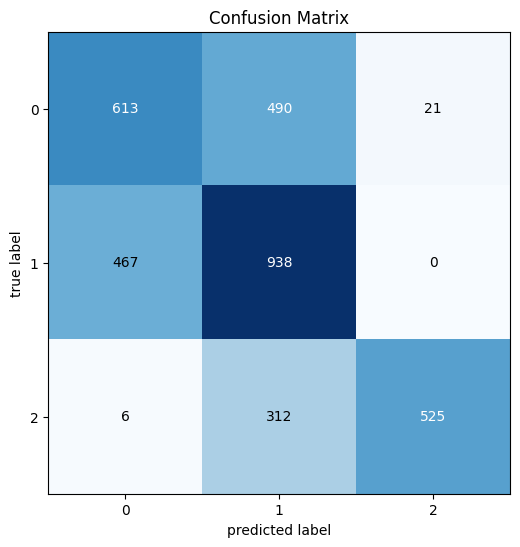

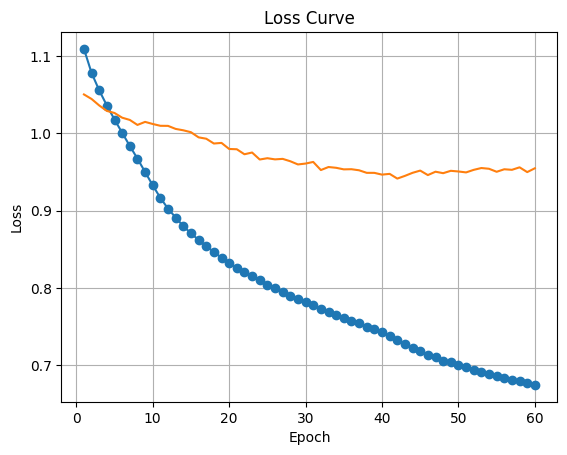

In [164]:
# x = np.concatenate((moved_normed_X_train_T1, moved_normed_X_train_T2, moved_normed_X_train_T3), axis = 0)
x = reshape_data(moved_normed_X_train)
# x_test = np.concatenate((moved_normed_X_test_T1, moved_normed_X_test_T2, moved_normed_X_test_T3), axis = 0)
x_test = reshape_data(moved_normed_X_test)
y = Y_train_shaped
y_test = Y_test_shaped

nn_train_test(x, y, x_test, y_test, CNN3Class(0, 3, 2), 5e-6, 0, 60, 64)

Epoch 1
-------------------------------
loss: 1.046698  [   64/12926]
loss: 1.018052  [ 6464/12926]
loss: 0.980973  [12864/12926]
Train set accuracy: 0.546
Train set classification Report:
               precision    recall  f1-score   support

           0       0.64      0.48      0.55      3934
           1       0.52      0.56      0.54      5620
           2       0.51      0.60      0.55      3372

    accuracy                           0.55     12926
   macro avg       0.56      0.55      0.55     12926
weighted avg       0.56      0.55      0.55     12926

Test set accuracy: 0.669
Test set classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1124
           1       0.66      0.53      0.59      1405
           2       0.64      0.95      0.77       843

    accuracy                           0.67      3372
   macro avg       0.67      0.70      0.67      3372
weighted avg       0.67      0.67      0.66  

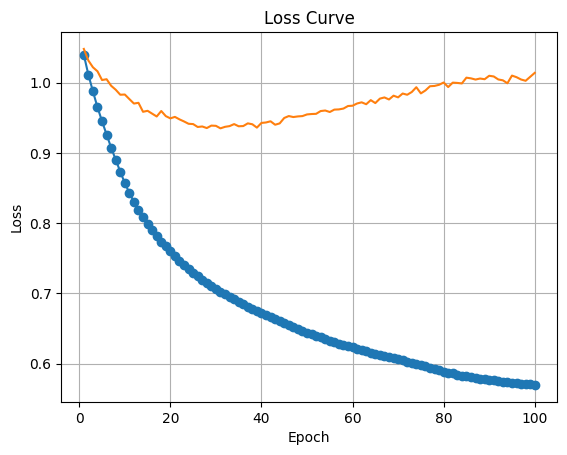

In [ ]:
x = reshape_data(moved_normed_X_train)
x_test = reshape_data(moved_normed_X_test)
y = Y_train_shaped
y_test = Y_test_shaped

nn_train_test(x, y, x_test, y_test, CNN3Class(0, 3, 2), 4e-6, 0, 100, 64)

In [ ]:
x_test.shape

(13800, 3, 1701)

## DNN

In [132]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
def nn_train_test(X_train, y_train, X_test, y_test, model, lr=1e-6, weight_decay=1e-7, num_batches=10, batch_size=16):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = "cpu"
    # print("Using device:", device)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    model.to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    num_epochs = num_batches
    loss_values = []
    test_loss_values = []
    for epoch in range(num_epochs):
        # print(f"Epoch {epoch+1}\n-------------------------------")
        loss_values.append(train(train_loader, model, criterion, optimizer))
        test_loss_values.append(evaluate_model(model, train_loader, test_loader, criterion))

    draw_result(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, model)
    plt.figure()
    plt.plot(range(1, num_epochs+1), loss_values, marker='o')
    plt.plot(range(1, num_epochs+1), test_loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.show()

### one-component DNN

In [64]:
x.shape

(12926, 3, 1701)

train set accuracy: 0.899
train set classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      3934
           1       0.89      0.95      0.92      5620
           2       0.85      0.86      0.86      3372

    accuracy                           0.90     12926
   macro avg       0.90      0.89      0.89     12926
weighted avg       0.90      0.90      0.90     12926

test set accuracy: 0.302
test set classification Report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      1124
           1       0.23      0.28      0.25      1405
           2       0.10      0.06      0.07       843

    accuracy                           0.30      3372
   macro avg       0.28      0.28      0.28      3372
weighted avg       0.29      0.30      0.29      3372



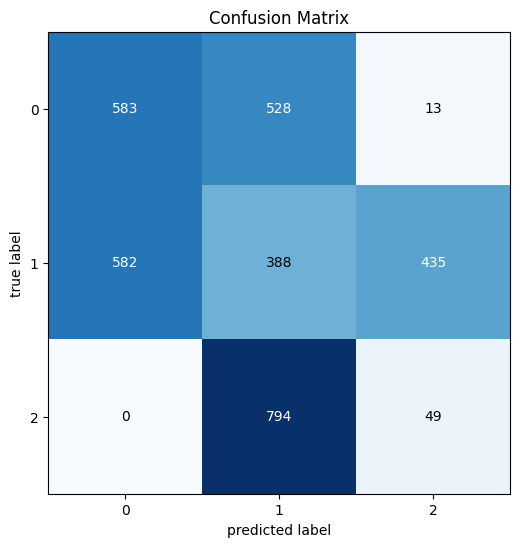

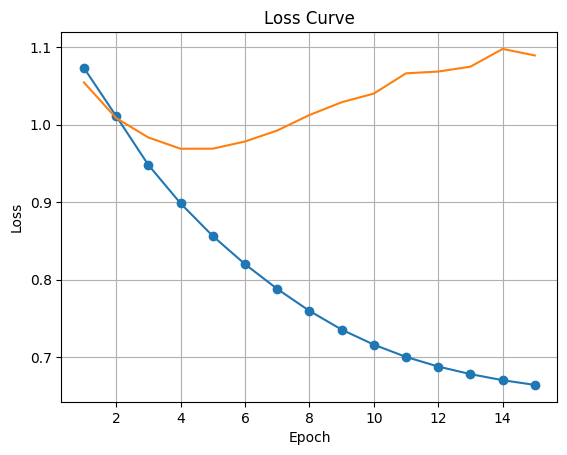

In [183]:
x = reshape_data(moved_normed_X_train)
x_test = reshape_data(moved_normed_X_test)
y = Y_train_shaped
y_test = Y_test_shaped

components = ['532nm', '638nm']

nn_train_test(x[:,1,:], y, x_test[:,1,:], y_test, DNNModel3(0, 3, 1701), 1e-6, 0, 15, 64)

In [175]:
x = reshape_data(moved_normed_X_train)
x_test = reshape_data(moved_normed_X_test)
x = np.concatenate((x[:,0,:], x[:,1,:], x[:,2,:]), axis=-1)
x_test = np.concatenate((x_test[:,0,:], x_test[:,1,:], x_test[:,2,:]), axis=-1)

y = Y_train_shaped
y_test = Y_test_shaped

components = ['532nm', '638nm', '785nm']

nn_train_test(x, y, x_test, y_test, DNNModel2(0.8, 3, 5103), 1e-6, 0, 30, 64)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x5103 and 1701x8096)

train set accuracy: 0.881
train set classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      3934
           1       0.91      0.96      0.93      5620
           2       0.81      0.76      0.79      3372

    accuracy                           0.88     12926
   macro avg       0.87      0.86      0.87     12926
weighted avg       0.88      0.88      0.88     12926

test set accuracy: 0.752
test set classification Report:
               precision    recall  f1-score   support

           0       1.00      0.27      0.42      1124
           1       0.63      1.00      0.77      1405
           2       1.00      0.99      0.99       843

    accuracy                           0.75      3372
   macro avg       0.87      0.75      0.73      3372
weighted avg       0.84      0.75      0.71      3372



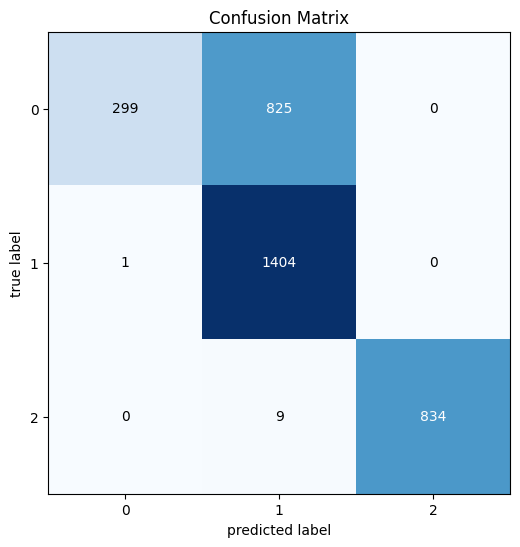

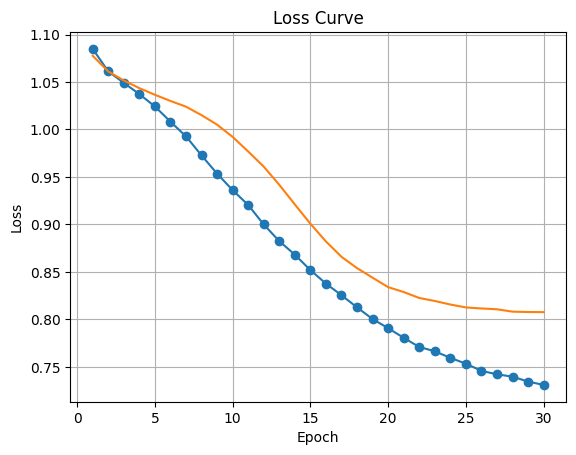

In [173]:
x = reshape_data(moved_normed_X_train)
x_test = reshape_data(moved_normed_X_test)
x = np.concatenate((x[:,0,:], x[:,1,:], x[:,2,:]), axis=-1)
x_test = np.concatenate((x_test[:,0,:], x_test[:,1,:], x_test[:,2,:]), axis=-1)

y = Y_train_shaped
y_test = Y_test_shaped

nn_train_test(x, y, x_test, y_test, DNNModel3(0.8, 3, 5103), 2e-6, 0, 30, 64)